In [1]:
from pathlib import Path
import numpy as np

from my_types import Quat, ScalarBatch, QuatBatch
from io_csv import load_gyro_base, load_ref
from pipelines import integrate_gyro
from evaluation import calc_angle_err, print_err_status, save_err_csv, plot_err_from_csv
from resample import find_stable_start_idx, cut_sample
from Tee import Tee

In [2]:
sample_1: str = "data01_21:08_oct_07_2025_5min"
sample_2: str = "data02_21:23_oct_07_2025_9min"
sample_3: str = "data03_21:41_oct_07_2025_13min"
sample_4: str = "data04_18:52_oct_08_2025_96min"

sample: str = sample_1

root: Path = Path.cwd().parent
run_dir: Path = root / "data" / sample

ori_path: Path = run_dir / "Orientation.csv"
gyro_path: Path = run_dir / "Gyroscope.csv"

for p in [ori_path, gyro_path]:
        if not p.exists():
                raise FileNotFoundError(f"File not found: {p}")

out_dir: Path = root / "output" / sample
out_dir.mkdir(parents=True, exist_ok=True)

out_log: Path = out_dir / "01_exp1_log.txt"

if out_log.is_file():
        out_log.unlink()

In [3]:
t_src_gyro, w_src_gyro, dt, t_new, w_avg_gyro = load_gyro_base(gyro_path)

q_ref_interp = load_ref(ori_path, t_new)
q_ref_interp /= np.linalg.norm(q_ref_interp, axis=1, keepdims=True)

In [4]:
# exp 1-1: Gyro-only, no sample cut

with Tee(out_log):
        dt_1, t_new_1, w_avg_gyro_1, q_ref_interp_1 = [dt, t_new, w_avg_gyro, q_ref_interp]

        q0_1: Quat = q_ref_interp_1[0].copy()
        q_gyro_1: QuatBatch = integrate_gyro(q0_1, w_avg_gyro_1, dt_1)

        angle_err_gyro_1: ScalarBatch = calc_angle_err(q_gyro_1, q_ref_interp_1)
        print_err_status("Gyro only: no sample cut", angle_err_gyro_1)



[START] 2026-02-26 21:03:15.394



Gyro only: no sample cut angle error in rad — min/max/mean/p90
0.016900799939842653 1.0850920070565426 0.5475108313340219 0.6285622393965337

Gyro only: no sample cut angle error in deg — min/max/mean/p90
0.9683445069479396 62.171192387719636 31.370059873138523 36.01396347871306

[END] 2026-02-26 21:03:17.521




In [5]:
with Tee(out_log):
        idx_cut: int = find_stable_start_idx(dt, w_avg_gyro, q_ref_interp,
                                sample_window=1000, threshold=0.5, sample_hz=100,
                                consecutive=3, min_cut_second=10, max_cut_second=30)
        t_cut: int = idx_cut / 100



[START] 2026-02-26 21:03:17.536

[INFO] Stabilization detected too early (< min_cut), applying min_cut=10s policy

[END] 2026-02-26 21:03:17.821




In [6]:
# exp 1-2: Gyro-only, sample cut

with Tee(out_log):
        dt_2, t_new_2, w_avg_gyro_2, q_ref_interp_2 = cut_sample(idx_cut, [dt, t_new, w_avg_gyro, q_ref_interp])

        q0_2: Quat = q_ref_interp_2[0].copy()
        q_gyro_2: QuatBatch = integrate_gyro(q0_2, w_avg_gyro_2, dt_2)

        angle_err_gyro_2: ScalarBatch = calc_angle_err(q_gyro_2, q_ref_interp_2)
        print_err_status("Gyro only: sample cut " + str(t_cut) + "s", angle_err_gyro_2)



[START] 2026-02-26 21:03:17.836

Gyro only: sample cut 10.0s angle error in rad — min/max/mean/p90
0.002692606276233363 1.41733946975559 0.39107310298265935 0.5663011403381867

Gyro only: sample cut 10.0s angle error in deg — min/max/mean/p90
0.15427497551860841 81.2075697543053 22.406838281991387 32.446665274823836

[END] 2026-02-26 21:03:19.815




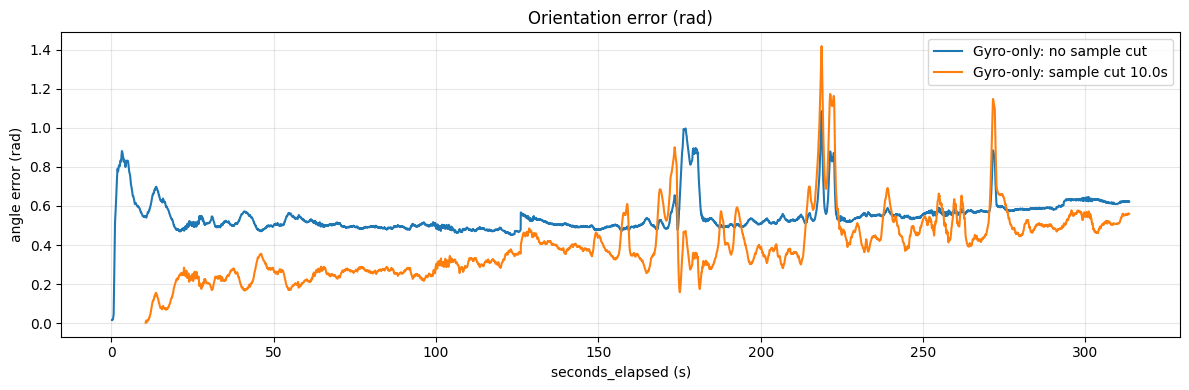

In [7]:
out_path_1: Path = out_dir / "01_exp1-1_angle_err_gyro.csv"
out_path_2: Path = out_dir / "01_exp1-2_angle_err_gyro.csv"
save_err_csv(out_path_1, t_new_1, angle_err_gyro_1)
save_err_csv(out_path_2, t_new_2, angle_err_gyro_2)

plot_err_from_csv([
        ("Gyro-only: no sample cut", out_path_1),
        ("Gyro-only: sample cut " + str(t_cut) + "s", out_path_2)],
                  out_dir / "01_exp1")